In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

In [1]:
#functions:

def i_n(series):
    i = 0
    dftest = adfuller(np.diff(series,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(series,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [2]:
p1_gen = pd.read_csv('../../data/p1_gen_dtindex.csv', index_col=0, parse_dates=True)
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
# the index has been preserved as a date time object, along with time stamps.

print(type(p1_gen.index))
p1_gen.index

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               '2020-05-15 00:00:00', '2020-05-15 00:00:00',
               ...
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00',
               '2020-06-17 23:45:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=68778, freq=None)

---

# FSM - using 5 days

In [4]:
# making copy of og df

pred_gen_og = p1_gen.copy()

In [5]:
# Seeing the month of june here.

pred_gen_jun = pred_gen_og[(pred_gen_og.index.month == 6)]
pred_gen_jun = pred_gen_jun.groupby('DATE_TIME').sum()
pred_gen_jun

# per the plot below, there is a drop off in the beginning of the month.

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-06-01 00:00:00,90970022,0.0,0.0,5407.250000,153519480.0
2020-06-01 00:15:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:30:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:45:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 01:00:00,90970022,0.0,0.0,0.000000,153519480.0
...,...,...,...,...,...
2020-06-17 22:45:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:00:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:15:00,90970022,0.0,0.0,129571.000000,156142755.0


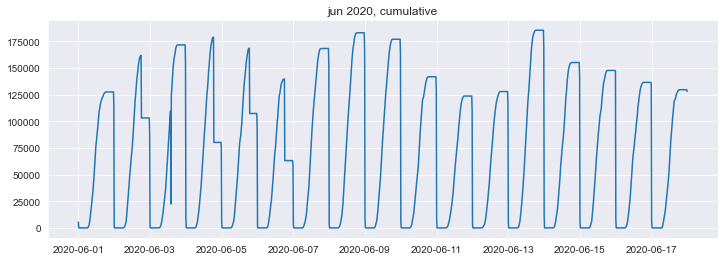

In [16]:
plt.subplots(figsize = (12,4))
plt.plot(pred_gen_jun.DAILY_YIELD)
plt.title('jun 2020, cumulative');

In [8]:
# data from 6/13 and on

pred_gen = pred_gen_jun[pred_gen_jun.index >= '2020-06-13 00:00:00'][['DAILY_YIELD']]
# Note: df['col'] returns a series. And, you can use the to_frame method to convert that series into a dataframe. Or use the double brackets, [[]].

pred_gen

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [9]:
pred_gen.shape

(478, 1)

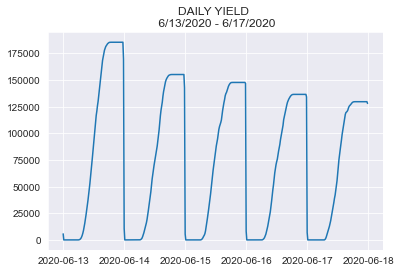

In [10]:
plt.plot(pred_gen)
plt.title('DAILY YIELD \n 6/13/2020 - 6/17/2020');

In [11]:
# checking number of records per day (for seasonality (m) within ARIMA):

print(len(pred_gen[pred_gen.index.day == 13]))
print(len(pred_gen[pred_gen.index.day == 14]))
print(len(pred_gen[pred_gen.index.day == 15]))
print(len(pred_gen[pred_gen.index.day == 16]))
print(len(pred_gen[pred_gen.index.day == 17]))

96
96
96
96
94


## Dickey-Fuller Test

In [12]:
result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.6038808334484527
p-value : 0.09219782793309467
#Lags Used : 1
Number of Observations Used : 476
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Test-Train Split

(382, 1) (96, 1)


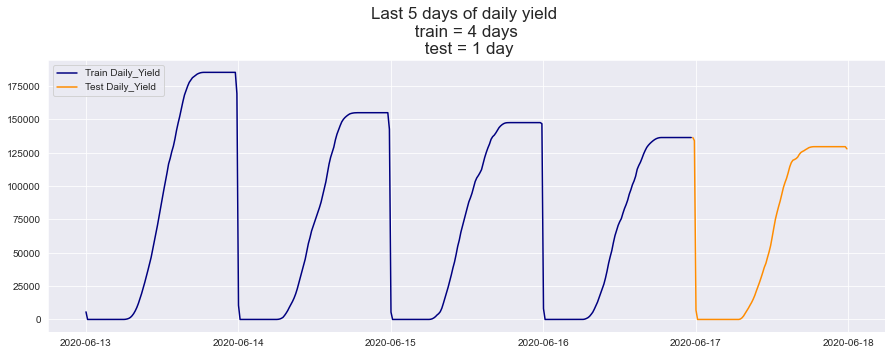

In [13]:
df = pred_gen
eotri_percent = .8

eotri = round(df.shape[0] * eotri_percent)

train = df[:eotri]
test = df[eotri:]

print(train.shape, test.shape)

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train, label='Train Daily_Yield', color='navy')
ax.plot(test, label='Test Daily_Yield', color='darkorange')
ax.set_title('Last 5 days of daily yield \n train = 4 days \n test = 1 day', fontsize=17)
ax.legend(loc='upper left')
plt.show()

In [14]:
train.head()

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000


In [15]:
test.head()

,DAILY_YIELD
DATE_TIME,
2020-06-16 23:30:00,136429.000000
2020-06-16 23:45:00,134079.375000
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000


## auto_arima

In [76]:
# Number of differencing needed for stationarity:

i = i_n(train.DAILY_YIELD)
i

1

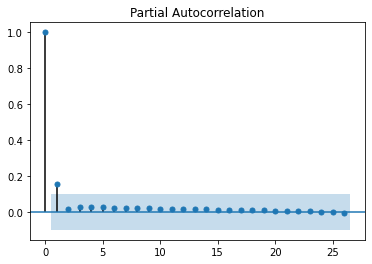

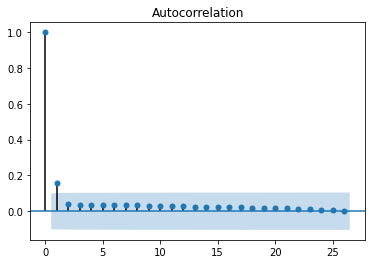

In [78]:
plot_pacf(np.diff(train.DAILY_YIELD,i)); #ar

plot_acf(np.diff(train.DAILY_YIELD,i)); #ma

#### Per above, the best ar,i,ma values = 1,1,1

let's check with auto_arima below:

In [72]:
arima_model = auto_arima(train,
                         start_p=0,d=i,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=5059.795, Time=2.20 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=4760.696, Time=40.67 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(0,1,1)[96]             : AIC=4729.300, Time=46.90 sec
 ARIMA(0,1,1)(0,1,0)[96]             : AIC=5030.109, Time=2.16 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(1,1,1)[96]             : AIC=4729.189, Time=64.96 sec
 ARIMA(0,1,1)(1,1,0)[96]             : AIC=4747.323, Time=44.76 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(1,1,1)[96]             : AIC=4883.187, Time=22.90 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(1,1,1)[96]             : AIC=4727.699, Time=121.42 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(0,1,1)[96]             : AIC=4728.472, Time=85.37 sec
 ARIMA(1,1,1)(1,1,0)[96]             : AIC=4742.032, Time=81.31 sec
 ARIMA(1,1,1)(0,1,0)[96]             : AIC=5022.163, Time=3.13 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96]             : AIC=4742.506, Time=69.16 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likel

 ARIMA(2,1,1)(1,1,1)[96]             : AIC=4729.699, Time=141.54 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(1,1,2)(1,1,1)[96]             : AIC=4850.318, Time=131.86 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,2)(1,1,1)[96]             : AIC=4852.669, Time=40.54 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,0)(1,1,1)[96]             : AIC=4730.361, Time=103.78 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(2,1,2)(1,1,1)[96]             : AIC=4843.155, Time=164.26 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(1,1,1)[96] intercept   : AIC=4729.256, Time=119.97 sec

Best model:  ARIMA(1,1,1)(1,1,1)[96]          
Total fit time: 1287.158 seconds


## Predicting

In [159]:
prediction = pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.head()

,0
DATE_TIME,
2020-06-16 23:30:00,132158.159163
2020-06-16 23:45:00,-6416.239443
2020-06-17 00:00:00,-13815.392282
2020-06-17 00:15:00,-13815.939811
2020-06-17 00:30:00,-13815.908646


In [160]:
prediction.columns = ['predicted_daily_yield']
prediction.head()

,predicted_daily_yield
DATE_TIME,
2020-06-16 23:30:00,132158.159163
2020-06-16 23:45:00,-6416.239443
2020-06-17 00:00:00,-13815.392282
2020-06-17 00:15:00,-13815.939811
2020-06-17 00:30:00,-13815.908646


In [168]:
prediction[prediction < 0] = 0
prediction

,predicted_daily_yield,actual_daily_yield
DATE_TIME,,
2020-06-16 23:30:00,132158.159163,136429.000000
2020-06-16 23:45:00,0.000000,134079.375000
2020-06-17 00:00:00,0.000000,6955.232143
2020-06-17 00:15:00,0.000000,0.000000
2020-06-17 00:30:00,0.000000,0.000000
...,...,...
2020-06-17 22:45:00,126583.301951,129571.000000
2020-06-17 23:00:00,126583.301677,129571.000000
2020-06-17 23:15:00,126583.306387,129571.000000


In [169]:
prediction['actual_daily_yield'] = test.DAILY_YIELD
prediction.head()

,predicted_daily_yield,actual_daily_yield
DATE_TIME,,
2020-06-16 23:30:00,132158.159163,136429.000000
2020-06-16 23:45:00,0.000000,134079.375000
2020-06-17 00:00:00,0.000000,6955.232143
2020-06-17 00:15:00,0.000000,0.000000
2020-06-17 00:30:00,0.000000,0.000000


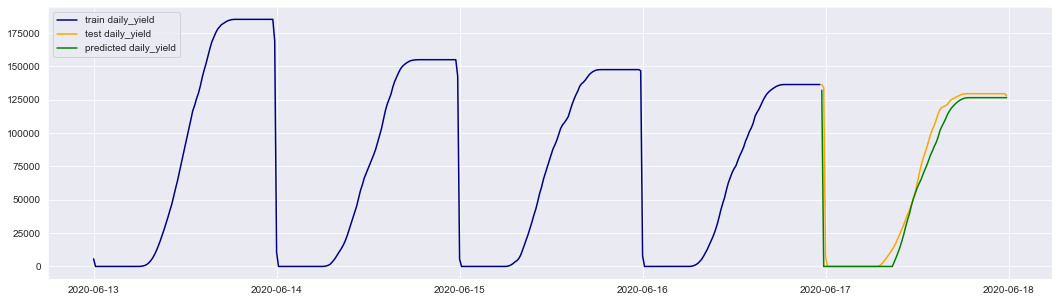

In [170]:
fig,ax = plt.subplots(figsize = (18,5))

ax.plot(train.DAILY_YIELD, label = 'train daily_yield', color = 'navy')
ax.plot(test.DAILY_YIELD, label = 'test daily_yield', color = 'orange')
ax.plot(prediction.predicted_daily_yield, label = 'predicted daily_yield', color = 'green')
ax.legend(loc = 'upper left')
plt.show()

In [171]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  382
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 96)   Log Likelihood               -2358.850
Date:                            Tue, 17 Nov 2020   AIC                           4727.699
Time:                                    17:01:52   BIC                           4745.962
Sample:                                         0   HQIC                          4735.020
                                            - 382                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0974      0.119      0.822      0.411      -0.135       0.330
ma.L1          0.2436      0.131   

In [172]:
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_daily_yield'],test['DAILY_YIELD'])))
print('-'*15)

print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_daily_yield'],test['DAILY_YIELD'])))
print('-'*15)

print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['predicted_daily_yield'],test['DAILY_YIELD'],squared=False)))

SARIMAX R2 Score: 0.924322
---------------
SARIMAX MAE Score: 6103.335073
---------------
SARIMAX RMSE Score: 15295.662211


## Forecasting 
2 days ahead

In [130]:
# doing calculations for how many 'n's we need (n = periods). 
# We're going to use 2 more n's than what we have here to complete 2 days forward

print(24*60, 24*60*2, 24*60/15, 24*60/15*2)

1440 2880 96.0 192.0


In [143]:
# checking last index in test

test.index[-1]

Timestamp('2020-06-17 23:45:00')

In [129]:
# make a list of future dates with time stamps, to use as index when forecasting below

future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15)]
# 2880 doesn't go all the way to the end of 2 days, bc we're starting earlier
# so use 2910

In [128]:
future_dates

[Timestamp('2020-06-17 23:45:00'),
 Timestamp('2020-06-18 00:00:00'),
 Timestamp('2020-06-18 00:15:00'),
 Timestamp('2020-06-18 00:30:00'),
 Timestamp('2020-06-18 00:45:00'),
 Timestamp('2020-06-18 01:00:00'),
 Timestamp('2020-06-18 01:15:00'),
 Timestamp('2020-06-18 01:30:00'),
 Timestamp('2020-06-18 01:45:00'),
 Timestamp('2020-06-18 02:00:00'),
 Timestamp('2020-06-18 02:15:00'),
 Timestamp('2020-06-18 02:30:00'),
 Timestamp('2020-06-18 02:45:00'),
 Timestamp('2020-06-18 03:00:00'),
 Timestamp('2020-06-18 03:15:00'),
 Timestamp('2020-06-18 03:30:00'),
 Timestamp('2020-06-18 03:45:00'),
 Timestamp('2020-06-18 04:00:00'),
 Timestamp('2020-06-18 04:15:00'),
 Timestamp('2020-06-18 04:30:00'),
 Timestamp('2020-06-18 04:45:00'),
 Timestamp('2020-06-18 05:00:00'),
 Timestamp('2020-06-18 05:15:00'),
 Timestamp('2020-06-18 05:30:00'),
 Timestamp('2020-06-18 05:45:00'),
 Timestamp('2020-06-18 06:00:00'),
 Timestamp('2020-06-18 06:15:00'),
 Timestamp('2020-06-18 06:30:00'),
 Timestamp('2020-06-

In [141]:
f_prediction = pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns = ['forecasted_daily_yield']

# zero out neg numbers. I can do the following bc my column is datatype numeric. so it'll zero out all neg values in the df
f_prediction[f_prediction < 0] = 0
f_prediction

,forecasted_daily_yield
2020-06-17 23:45:00,132158.159163
2020-06-18 00:00:00,0.000000
2020-06-18 00:15:00,0.000000
2020-06-18 00:30:00,0.000000
2020-06-18 00:45:00,0.000000
...,...
2020-06-19 23:00:00,116636.739143
2020-06-19 23:15:00,116636.662970
2020-06-19 23:30:00,116637.982359
2020-06-19 23:45:00,112610.389590


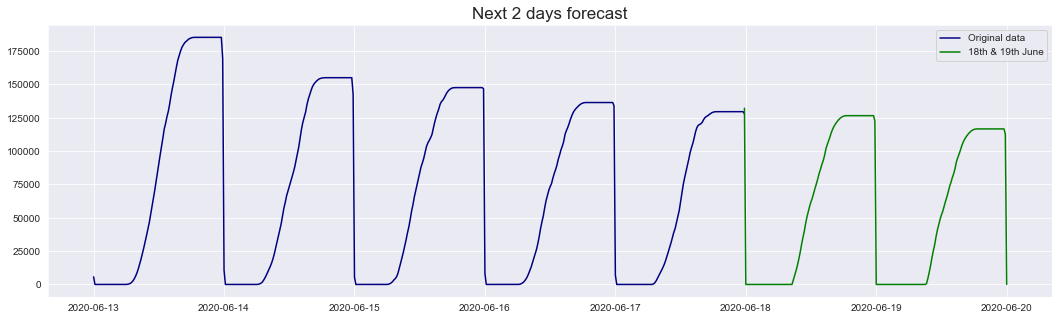

In [142]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(pred_gen.DAILY_YIELD, label = 'Original data', color = 'navy')
ax.plot(f_prediction.forecasted_daily_yield, label='18th & 19th June', color = 'green')
ax.legend()
ax.set_title('Next 2 days forecast', size=17)
plt.show()

---

# May

- look at may data, and see if we can predict jun

In [17]:
# Seeing the month of may here.

pred_gen_may = pred_gen_og[(pred_gen_og.index.month == 5)]
pred_gen_may = pred_gen_may.groupby('DATE_TIME').sum()
pred_gen_may

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-05-15 00:00:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:15:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:30:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 00:45:00,86835021,0.0,0.0,0.000000,143581676.0
2020-05-15 01:00:00,90970022,0.0,0.0,0.000000,150761642.0
...,...,...,...,...,...
2020-05-31 22:45:00,90970022,0.0,0.0,125291.000000,153519480.0
2020-05-31 23:00:00,90970022,0.0,0.0,125291.000000,153519480.0
2020-05-31 23:15:00,90970022,0.0,0.0,125291.000000,153519480.0


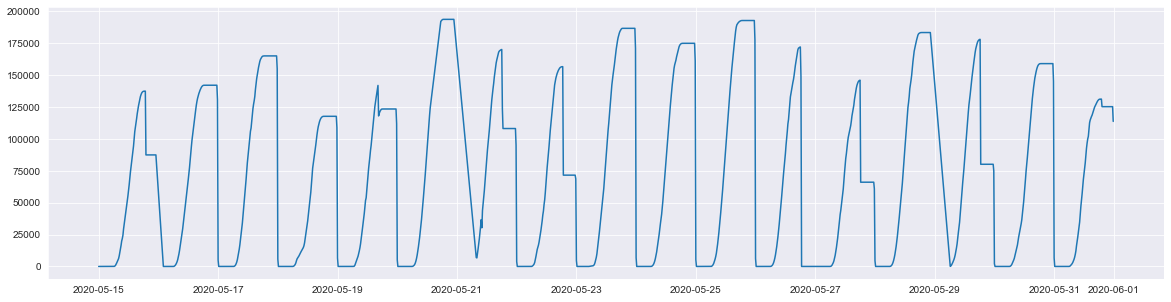

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(pred_gen_may.DAILY_YIELD)
plt.show()